In [50]:
# %pip install selenium
# %pip install beautifulsoup4
# %pip install webdriver-manager
# %pip install tabulate

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import random
import json
import os

In [2]:
base_url = "https://batdongsan.com.vn"
list_page_base_url = f"{base_url}/nha-dat-ban-ha-noi"

### Cấu hình Webdriver để tối ưu hoá chống chặn bot

In [3]:
options = Options()
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)


In [54]:

data = []
processed_links = set()
page_number = 1
max_pages = 150 # Giới hạn số trang bạn muốn cào dữ liệu
file_path = "batdongsan_data.json" # Đặt tên file ở ngoài để dễ truy cập

In [55]:
# BƯỚC 1: ĐỌC LẠI DỮ LIỆU ĐÃ CÓ (nếu có)
if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"Đã tải lại {len(data)} tin đăng từ file cũ.")
    # Cập nhật processed_links để tránh cào lại
    for item in data:
        if 'link' in item:
            processed_links.add(item['link'])

Đã tải lại 2924 tin đăng từ file cũ.


In [ ]:
# VÒNG LẶP CHÍNH XỬ LÝ PHÂN TRANG
while page_number <= max_pages:
    # 1. TẠO URL TRANG HIỆN TẠI
    if page_number == 1:
        current_page_url = list_page_base_url
    else:
        current_page_url = f"{list_page_base_url}/p{page_number}"

    print(f"--- Đang cào trang danh sách #{page_number}: {current_page_url} ---")
    
    try:
        # 2. TRUY CẬP TRANG VÀ CHỜ TẢI
        driver.get(current_page_url)
        time.sleep(random.uniform(5, 8)) 

        # 3. LẤY NỘI DUNG HTML TRANG DANH SÁCH
        list_html = driver.page_source
        list_soup = BeautifulSoup(list_html, "html5lib")

        # 4. TÌM TẤT CẢ TIN ĐĂNG
        listings = list_soup.find_all('div', class_='js__card')
        
        if not listings:
            print(f"Không tìm thấy tin đăng nào trên trang {page_number}. Đã đạt đến trang cuối hoặc bị chặn. Dừng lại.")
            break 
        
        # Danh sách tạm thời chứa dữ liệu cào được từ trang này
        page_links = []
        
        # --------------------------------
        # BƯỚC 2: TRÍCH XUẤT THÔNG TIN CƠ BẢN TỪ TRANG DANH SÁCH
        # --------------------------------
        for listing in listings:
            link_tag = listing.find('a', class_='js__product-link-for-product-id')
            relative_link = link_tag['href'] if link_tag and 'href' in link_tag.attrs else None
            
            if relative_link:
                full_link = f"{base_url}{relative_link}"
                if full_link not in processed_links:
                    processed_links.add(full_link)
                    
                    item_data = {}
                    item_data['title'] = listing.find('span', class_='pr-title').get_text(strip=True) if listing.find('span', class_='pr-title') else 'N/A'
                    item_data['price'] = listing.find('span', class_='re__card-config-price').get_text(strip=True) if listing.find('span', class_='re__card-config-price') else 'N/A'
                    
                    area_tag = listing.find('span', class_='re__card-config-area')
                    item_data['area'] = area_tag.get_text(strip=True).replace('·', '').replace('m²', ' m²') if area_tag else 'N/A'
                    
                    bedroom_tag = listing.find('span', class_='re__card-config-bedroom')
                    item_data['bedroom'] = bedroom_tag.find('span').get_text(strip=True) + ' PN' if bedroom_tag and bedroom_tag.find('span') else 'N/A'
                    
                    toilet_tag = listing.find('span', class_='re__card-config-toilet')
                    item_data['toilet'] = toilet_tag.find('span').get_text(strip=True) + ' WC' if toilet_tag and toilet_tag.find('span') else 'N/A'
                    
                    item_data['link'] = full_link
                    page_links.append(item_data)
            
        # --------------------------------
        # BƯỚC 3: TRUY CẬP VÀ TRÍCH XUẤT THÔNG TIN CHI TIẾT
        # --------------------------------
        for item_data in page_links:
            full_link = item_data['link']
            
            # --- Thông tin chi tiết mặc định ---
            item_data['address'] = 'N/A'
            item_data['legal'] = 'N/A'
            item_data['furniture'] = 'N/A'
            item_data['post_date'] = 'N/A'
            item_data['loai_bds'] = 'N/A' 

            try:
                driver.get(full_link)
                print(f"  > Đang truy cập chi tiết: {full_link}")
                time.sleep(random.uniform(3, 5)) 

                detail_html = driver.page_source
                detail_soup = BeautifulSoup(detail_html, "html5lib")
                
                # Trích xuất Ngày đăng
                post_date_div = detail_soup.find('div', class_='re__pr-short-info-item js__pr-config-item')
                if post_date_div:
                    title_span = post_date_div.find('span', class_='title')
                    value_span = post_date_div.find('span', class_='value')
                    if title_span and 'Ngày đăng' in title_span.get_text(strip=True):
                        item_data['post_date'] = value_span.get_text(strip=True) if value_span and value_span.get_text(strip=True) else 'N/A'
                
                # Trích xuất Địa chỉ chi tiết
                address_tag = detail_soup.select_one('span.re__pr-short-description.js__pr-address')
                if address_tag:
                    item_data['address'] = address_tag.get_text(strip=True)
                    
                # Trích xuất Pháp lý, Nội thất, Loại hình
                spec_tags = detail_soup.find_all('div', class_='re__pr-specs-content-item')
                for spec in spec_tags:
                    label_tag = spec.find('span', class_='re__pr-specs-content-item-title')
                    value_tag = spec.find('span', class_='re__pr-specs-content-item-value')
                    if label_tag and value_tag:
                        label = label_tag.get_text(strip=True)
                        value = value_tag.get_text(strip=True)
                        if 'Pháp lý' in label:
                            item_data['legal'] = value
                        elif 'Nội thất' in label:
                            item_data['furniture'] = value
                        elif 'Loại hình' in label: 
                            item_data['loai_bds'] = value
                            
            except Exception as e:
                print(f"  > Lỗi khi truy cập {full_link}: {e}")
                # Giữ nguyên giá trị mặc định 'N/A' nếu có lỗi

        # --------------------------------
        # LƯU DỮ LIỆU TĂNG CƯỜNG (Sau khi cào xong 1 trang)
        # --------------------------------
        data.extend(page_links) # Thêm dữ liệu của trang hiện tại vào danh sách chung
        
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        
        print(f"  >>> Đã lưu dữ liệu tạm thời. Tổng số tin hiện tại: {len(data)}")

        # 5. TĂNG SỐ TRANG
        page_number += 1
        
    except Exception as e:
        print(f"Lỗi chung khi xử lý trang danh sách {page_number}: {e}")
        break 
        
# Đóng trình duyệt
driver.quit()

# KẾT QUẢ CUỐI CÙNG
print("\n==============================")
print(f"Hoàn thành cào dữ liệu. Tổng số tin đăng cuối cùng: {len(data)}")
print("==============================")
print(f"Dữ liệu cuối cùng đã được lưu vào: {file_path}")

### 2. Hiển thị dữ liệu thu thập được, lưu lại trong file .CSV

In [5]:
import json
import pandas as pd
from tabulate import tabulate  # 👈 Thêm thư viện này để in bảng đẹp
from datetime import datetime
import re

In [7]:
# Đọc file JSON
with open("batdongsan_data.json", 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Chọn các cột cần hiển thị
cols = ['price', 'area', 'bedroom', 'toilet', "address", 'legal', 'furniture', 'post_date', 'loai_bds']

# Hiển thị 5 tin đầu dưới dạng bảng
print("\n 5 tin Bất Động Sản đầu tiên:\n")
print(tabulate(df[cols].head(), headers='keys', tablefmt='grid', showindex=False))

# Thống kê nhanh
print(f"\n Tổng số tin: {len(df):,}")

# Lưu ra file CSV
csv_file = "batdongsan.csv"
df.to_csv(csv_file, index=False, encoding='utf-8-sig', sep=';')
print(f"\nĐã lưu dữ liệu thành công vào file: {csv_file}")



 5 tin Bất Động Sản đầu tiên:

+----------------+----------+-----------+----------+-----------------------------------------------------------------+----------------+----------------+-------------+------------+
| price          | area     | bedroom   | toilet   | address                                                         | legal          | furniture      | post_date   | loai_bds   |
+================+==========+===========+==========+=================================================================+================+================+=============+============+
| Giá thỏa thuận | 63,1  m² | 2 PN      | 2 WC     | Dự án Vinhomes Ocean Park Gia Lâm, Xã Dương Xá, Gia Lâm, Hà Nội | Sổ đỏ/ Sổ hồng | Cơ bản         | 18/10/2025  | N/A        |
+----------------+----------+-----------+----------+-----------------------------------------------------------------+----------------+----------------+-------------+------------+
| 2 tỷ           | 100  m²  | N/A       | N/A      | Xã Phú Cát, Quố

### 3. Làm sạch dữ liệu (Xử lý giá trị thiếu, giá trị ngoại lai)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
csv_file_path = "batdongsan.csv"
normalized_csv_path = "batdongsan_normalized.csv"
try:
    df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file {csv_file_path}.")
    exit()


print(f"Số dòng dữ liệu gốc: {len(df)}")

# xem dữ liệu các giá trị khuyết thiếu của từng cột
print(df.isnull().sum())

Số dòng dữ liệu gốc: 2924
title         193
price           1
area            0
bedroom      1280
toilet       1423
link            0
address        26
legal         407
furniture    1420
post_date      26
loai_bds     2924
district     2924
dtype: int64


In [10]:
# Chuẩn hóa 'N/A' thành giá trị thiếu chuẩn (NaN)
df.replace('N/A', np.nan, inplace=True)
df.replace('="N/A"', np.nan, inplace=True)

In [11]:
# --- BƯỚC 2: CHUYỂN ĐỔI DỮ LIỆU SANG DẠNG SỐ ---
# Các hàm chuyển đổi này giống như trước, để đưa dữ liệu về dạng số
def clean_price(price_str):
    if pd.isnull(price_str) or 'giá thỏa thuận' in str(price_str).lower():
        return np.nan
    price_str = str(price_str).lower().replace(',', '.')
    if 'tỷ' in price_str:
        value = price_str.replace('tỷ', '').strip()
        try: return float(value)
        except ValueError: return np.nan
    elif 'triệu' in price_str:
        value = price_str.replace('triệu', '').strip()
        try: return float(value) / 1000
        except ValueError: return np.nan
    return np.nan

def clean_area(area_str):
    if pd.isnull(area_str): return np.nan
    try: return float(str(area_str).replace('m²', '').strip())
    except ValueError: return np.nan

def clean_rooms(room_str):
    if pd.isnull(room_str): return np.nan # Giữ là NaN để xử lý ở bước sau
    try: return int(''.join(filter(str.isdigit, str(room_str))))
    except ValueError: return np.nan

# Áp dụng hàm để tạo các cột số mới
df['price_ty'] = df['price'].apply(clean_price)
df['area_m2'] = df['area'].apply(clean_area)
df['bedrooms_num'] = df['bedroom'].apply(clean_rooms)
df['toilets_num'] = df['toilet'].apply(clean_rooms)

# Xóa các cột text gốc
df.drop(columns=['price', 'area', 'bedroom', 'toilet'], inplace=True)


In [12]:
# --- BƯỚC 3: XỬ LÝ GIÁ TRỊ THIẾU ---

# 3a. ÁP DỤNG QUY TẮC CHO BIẾN SỐ (NUMERIC)
# print("\nĐang xử lý giá trị thiếu cho các biến số...")

# Đối với giá, diện tích, số phòng điền bằng TRUNG VỊ (median)
median_price = df['price_ty'].median()
median_area = df['area_m2'].median()
df['price_ty'].fillna(median_price, inplace=True)
df['area_m2'].fillna(median_area, inplace=True)
print(f"-> Giá trị thiếu của 'price_ty' được thay thế bằng median: {median_price:.2f} tỷ")
print(f"-> Giá trị thiếu của 'area_m2' được thay thế bằng median: {median_area:.2f} m²")

median_bedrooms = df['bedrooms_num'].median()
median_toilets = df['toilets_num'].median()
df['bedrooms_num'].fillna(median_bedrooms, inplace=True)
df['toilets_num'].fillna(median_toilets, inplace=True)
print(f"-> Giá trị thiếu của 'bedrooms_num' được thay thế bằng median: {median_bedrooms:.0f} phòng")
print(f"-> Giá trị thiếu của 'toilets_num' được thay thế bằng median: {median_toilets:.0f} WC")

# 3b. ÁP DỤNG QUY TẮC CHO BIẾN PHÂN LOẠI (CATEGORICAL)


# Đọc file CSV (hoặc JSON gốc)

# 2. Định nghĩa hàm phân loại BĐS dựa trên URL
def classify_by_url(link):
    """Phân loại loại hình BĐS dựa trên các từ khóa trong URL."""
    link = str(link).lower()
    
    # 1. Căn hộ chung cư
    if 'ban-can-ho-chung-cu' in link:
        return 'Căn hộ chung cư'
    
    # 2. Đất nền/Thổ cư
    elif 'ban-dat' in link:
        return 'Đất nền/Thổ cư'
    
    # 3. Biệt thự/Liền kề
    # Kiểm tra pattern 'ban-nha-biet-thu-lien-ke' hoặc các từ khóa liên quan
    elif 'ban-nha-biet-thu-lien-ke' in link or 'biet-thu' in link or 'shophouse' in link or 'villa' in link:
        return 'Biệt thự/Liền kề'
    
    # 4. Nhà riêng/Khác (Nhà mặt phố, nhà trong ngõ)
    elif 'ban-nha-rieng' in link or 'ban-nha-mat-pho' in link:
        return 'Nhà riêng/Khác'
    
    # Fallback
    else:
        return 'Khác/Không rõ'
df['loai_bds'] = df['link'].apply(classify_by_url)

df['district'] = df['address'].apply(lambda x: x.split(',')[-2].strip() if isinstance(x, str) and len(x.split(',')) > 1 else 'Missing')


# Đối với address, điền bằng một danh mục mới
df['address'].fillna('Missing', inplace=True)

df['district'] = df['address'].apply(lambda x: x.split(',')[-2].strip() if isinstance(x, str) and len(x.split(',')) > 1 else 'Missing')


# Các cột khác như title, link nếu thiếu cũng có thể xử lý tương tự
df['title'].fillna('Missing', inplace=True)

df['furniture'].fillna('Missing', inplace=True)

df['legal'].fillna('Missing', inplace=True)

df['post_date'].fillna('Missing', inplace=True)

df['link'].fillna('Missing', inplace=True)

-> Giá trị thiếu của 'price_ty' được thay thế bằng median: 10.90 tỷ
-> Giá trị thiếu của 'area_m2' được thay thế bằng median: 82.00 m²
-> Giá trị thiếu của 'bedrooms_num' và 'toilets_num' được thay thế bằng 0.
-> Giá trị thiếu của 'address' được thay thế bằng nhóm 'Missing'.


/var/folders/v1/bq2j38t96wn_8cnc5crkt_sw0000gp/T/ipykernel_23558/2056093405.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_ty'].fillna(median_price, inplace=True)
/var/folders/v1/bq2j38t96wn_8cnc5crkt_sw0000gp/T/ipykernel_23558/2056093405.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [72]:
# --- BƯỚC 4: LƯU KẾT QUẢ ---
# Kiểm tra lại xem còn giá trị thiếu không
print("\nKiểm tra lại dữ liệu sau khi chuẩn hóa:")
print(df.isnull().sum())

# Lưu file CSV đã được chuẩn hóa
df.to_csv(normalized_csv_path, index=False, encoding='utf-8-sig')

print(f"\n Hoàn thành! Dữ liệu đã chuẩn hóa được lưu tại: {normalized_csv_path}")
print(f"Tổng số dòng cuối cùng: {len(df)} (đã giữ lại toàn bộ các dòng).")


Kiểm tra lại dữ liệu sau khi chuẩn hóa:
title           0
link            0
address         0
legal           0
furniture       0
post_date       0
loai_bds        0
price_ty        0
area_m2         0
bedrooms_num    0
toilets_num     0
district        0
dtype: int64

 Hoàn thành! Dữ liệu đã chuẩn hóa được lưu tại: batdongsan_normalized.csv
Tổng số dòng cuối cùng: 2569 (đã giữ lại toàn bộ các dòng).


In [73]:
df = pd.read_csv("batdongsan_normalized.csv", encoding='utf-8-sig')

In [74]:
# --- 2. Các cột cần xử lý ngoại lai ---
cols = ["price_ty", "area_m2", "bedrooms_num", "toilets_num"]

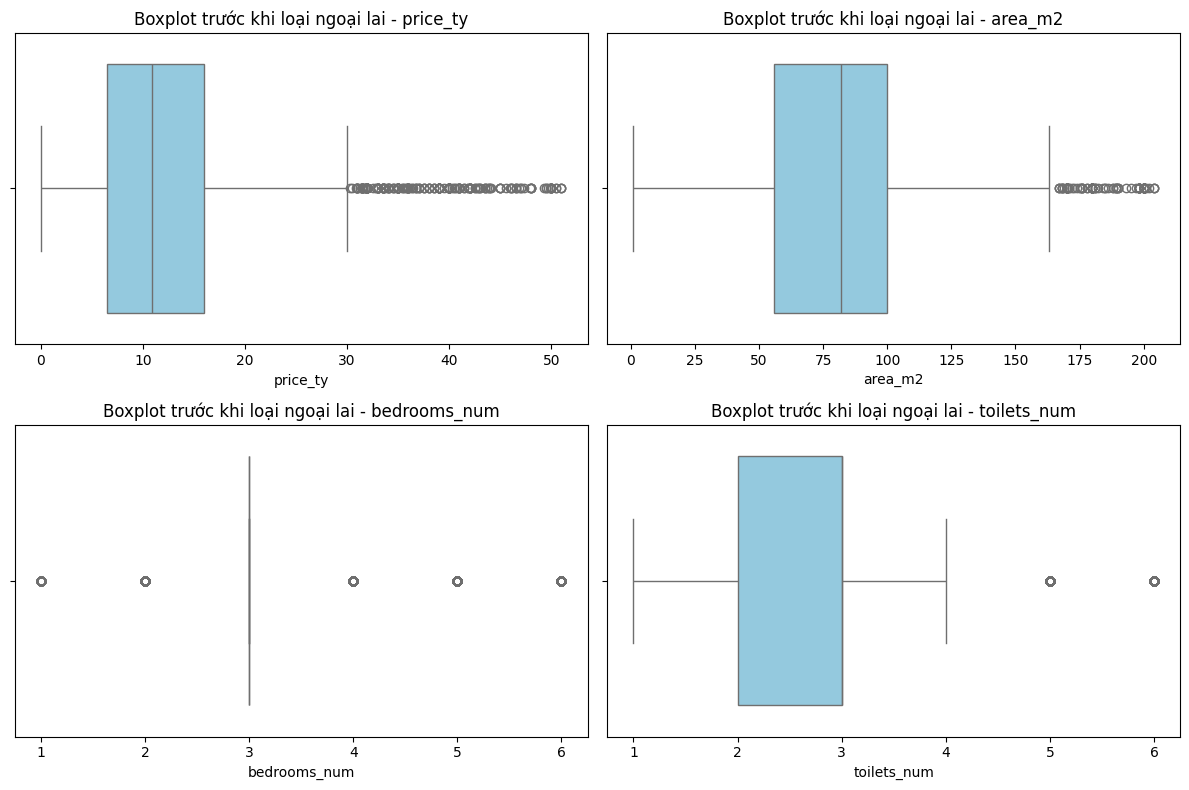

In [75]:
# --- 3. Vẽ boxplot trước khi loại bỏ ngoại lai ---
plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot trước khi loại ngoại lai - {col}")
plt.tight_layout()
output_path = os.path.join("img", "boxplot_before_outliers.png")
plt.savefig(output_path, bbox_inches='tight')
plt.show()

In [76]:
# --- 5. Hàm loại bỏ ngoại lai theo phương pháp IQR ---
def remove_outliers_IQR(data, col):
    if col == 'bedrooms_num' or col == 'toilets_num':
      Q1 = data[col].quantile(0)
    else:
      Q1 = data[col].quantile(0.2)

    Q3 = data[col].quantile(0.8)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

# --- 6. Loại bỏ ngoại lai ---
df_clean = df.copy()
for col in cols:
  if col == 'price_ty' or col == 'area_m2':
    df_clean = remove_outliers_IQR(df_clean, col)

# --- 7. In ra chiều dài dữ liệu sau khi loại bỏ ngoại lai ---
print("Số lượng bản ghi sau khi loại bỏ ngoại lai:", len(df_clean))

Số lượng bản ghi sau khi loại bỏ ngoại lai: 2410


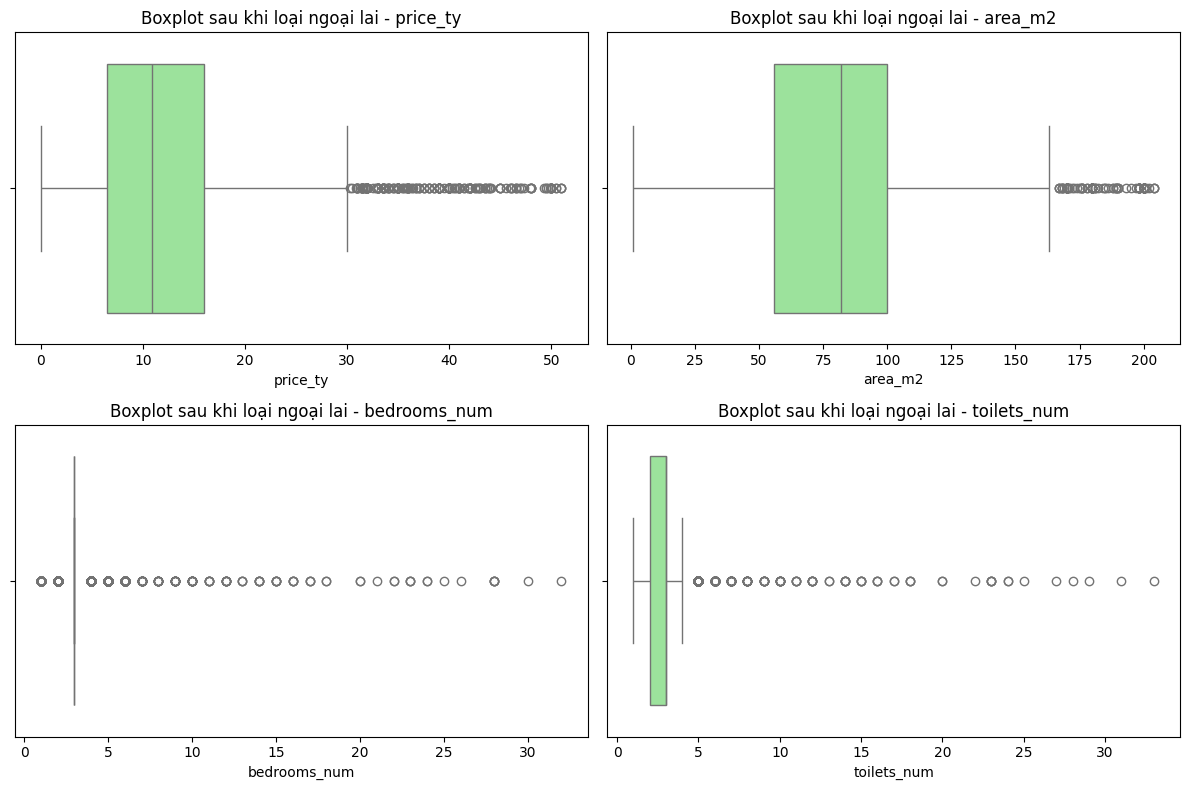

In [59]:
#--- 8. Vẽ boxplot sau khi loại bỏ ngoại lai ---
plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_clean[col], color="lightgreen")
    plt.title(f"Boxplot sau khi loại ngoại lai - {col}")
plt.tight_layout()
output_path = os.path.join("img", "boxplot_after_outliers.png")
plt.savefig(output_path, bbox_inches='tight')
plt.show()

In [62]:
df_clean.to_csv("batdongsan_data_no_outliers.csv", index=False, encoding='utf-8-sig')

### Co dãn và chuẩn hoá dữ liệu

In [ ]:
%pip install scikit-learn

In [63]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [64]:
df = pd.read_csv('batdongsan_data_no_outliers.csv')

# Xác định các cột định lượng để co giãn
quantitative_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nCác cột được co giãn:", list(quantitative_cols))

df_scaled = df.copy()

# Khởi tạo và áp dụng Min-Max Scaling
scaler = MinMaxScaler()
df_scaled[quantitative_cols] = scaler.fit_transform(df[quantitative_cols])

print(df_scaled.head())

# Lưu kết quả
output_filename = 'batdongsan_data_scaled.csv'
df_scaled.to_csv(output_filename, index=False)

print(f"\nThành công! Dữ liệu đã được co giãn và lưu vào tệp: '{output_filename}'")


Các cột được co giãn: ['price_ty', 'area_m2', 'bedrooms_num', 'toilets_num']
                                               title  \
0  Ban công Đông Nam - Không Mất Phí Môi Giới chí...   
1  Giá chỉ từ 2 tỷ, đất đô thị Hòa Lạc, gần QL21 ...   
2  Bán biệt thự mặt công viên 65hecta tại KĐT Cip...   
3                                            Missing   
4                                            Missing   

                                                link  \
0  https://batdongsan.com.vn/ban-can-ho-chung-cu-...   
1  https://batdongsan.com.vn/ban-dat-xa-phu-cat-1...   
2  https://batdongsan.com.vn/ban-nha-biet-thu-lie...   
3  https://batdongsan.com.vn/ban-dat-duong-hoi-ph...   
4  https://batdongsan.com.vn/ban-nha-rieng-duong-...   

                                             address             legal  \
0  Dự án Vinhomes Ocean Park Gia Lâm, Xã Dương Xá...    Sổ đỏ/ Sổ hồng   
1                       Xã Phú Cát, Quốc Oai, Hà Nội    Sổ đỏ/ Sổ hồng   
2  Dự án Kita Capital Cipu

### 5. Các biểu đồ trực quan

### 5.1 Đồ thị dạng đường thẳng

In [ ]:
%pip install cartopy


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Biểu đồ đã được lưu thành line_chart.png


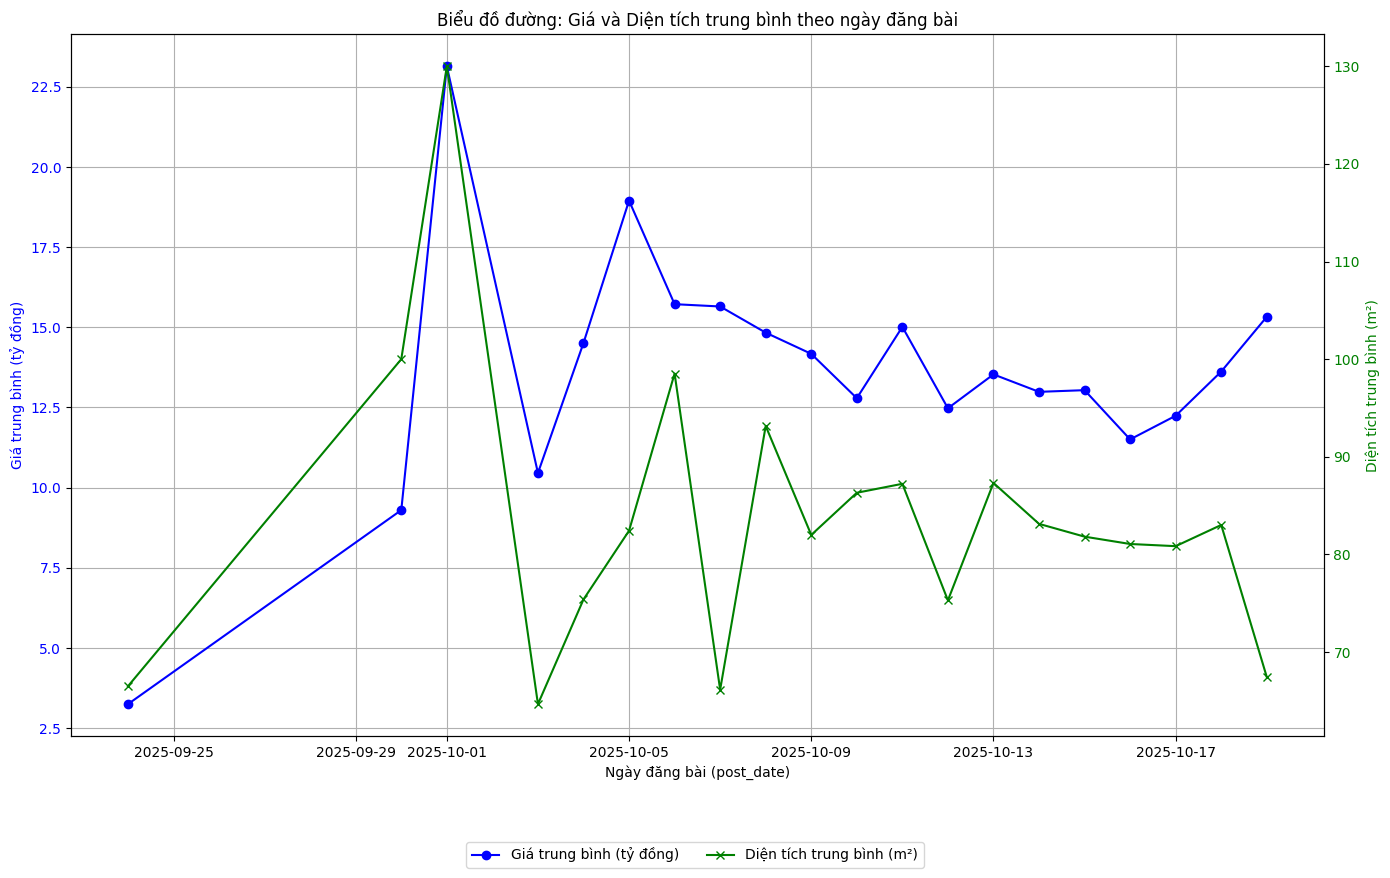

In [66]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('batdongsan_data_no_outliers.csv')

# Thay thế "Missing" trong cột post_date bằng NaN
df['post_date'] = df['post_date'].replace('Missing', pd.NA)

# Lọc bỏ các hàng có post_date là NaN
df = df.dropna(subset=['post_date'])

# Chuyển đổi post_date sang định dạng datetime
df['post_date'] = pd.to_datetime(df['post_date'], format='%d/%m/%Y')

# Sắp xếp DataFrame theo post_date
df = df.sort_values('post_date')

# Nhóm theo post_date và tính giá trị trung bình cho price_ty và area_m2
grouped = df.groupby('post_date')[['price_ty', 'area_m2']].mean().reset_index()

# Vẽ biểu đồ đường với hai trục y
fig, ax1 = plt.subplots(figsize=(14, 8))

# Vẽ đường cho price_ty (trục y bên trái)
ax1.plot(grouped['post_date'], grouped['price_ty'], label='Giá trung bình (tỷ đồng)', marker='o', color='blue')
ax1.set_xlabel('Ngày đăng bài (post_date)')
ax1.set_ylabel('Giá trung bình (tỷ đồng)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Tạo trục y thứ hai cho area_m2
ax2 = ax1.twinx()
ax2.plot(grouped['post_date'], grouped['area_m2'], label='Diện tích trung bình (m²)', marker='x', color='green')
ax2.set_ylabel('Diện tích trung bình (m²)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Tiêu đề và chú thích
plt.title('Biểu đồ đường: Giá và Diện tích trung bình theo ngày đăng bài')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()

# Lưu biểu đồ trước khi hiển thị
output_path = os.path.join("img", "line_chart.png")

plt.savefig(output_path, bbox_inches='tight')
print(f"Biểu đồ đã được lưu thành line_chart.png")

# Hiển thị biểu đồ
plt.show()

### 5.2.1 Đồ thị điểm rời rạc

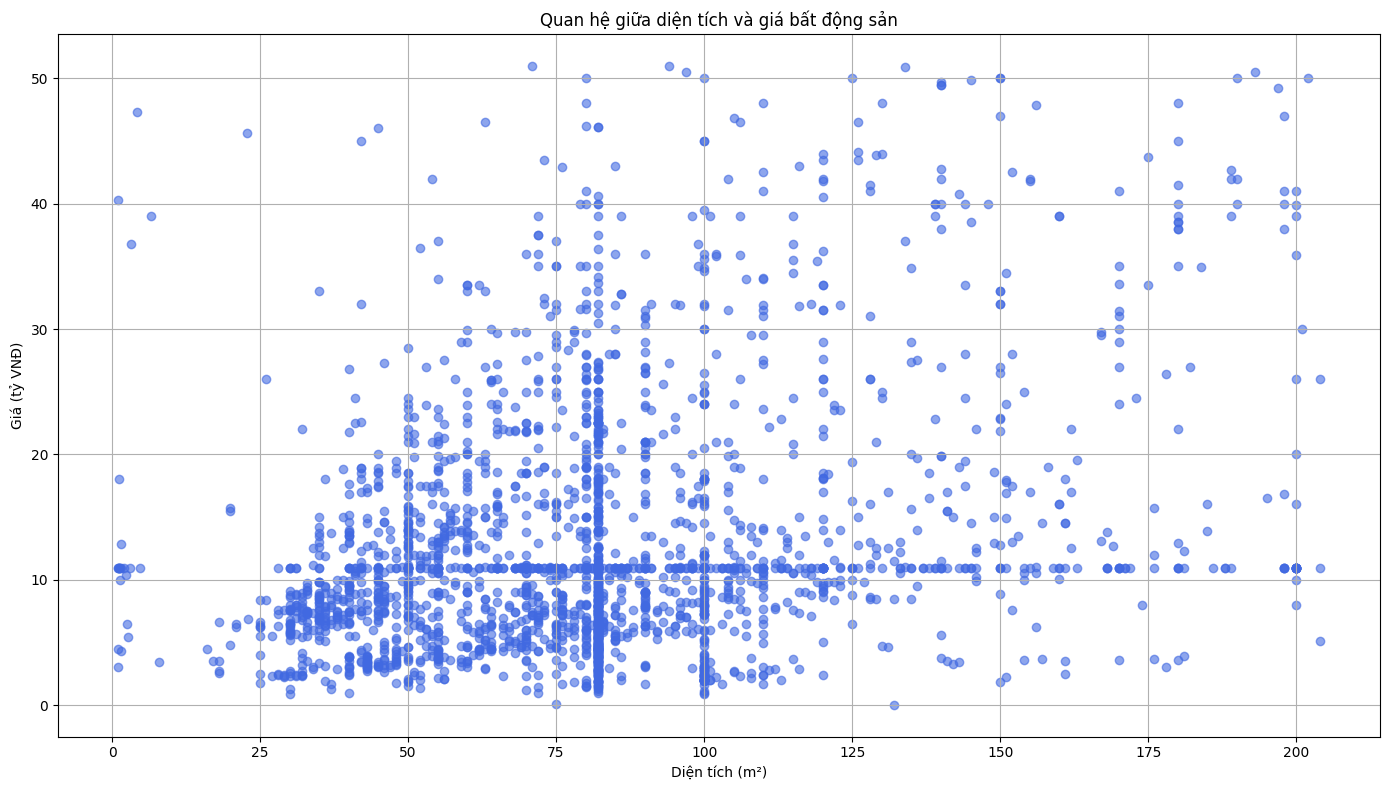

In [67]:

df = pd.read_csv("batdongsan_data_no_outliers.csv")

# Đảm bảo các cột cần thiết tồn tại
cols_needed = ['area_m2', 'price_ty', 'bedrooms_num', 'furniture']
for c in cols_needed:
    if c not in df.columns:
        raise ValueError(f"Thiếu cột {c} trong dữ liệu!")

# ---------------------------
# 2️⃣ Đồ thị điểm rời rạc cơ bản (Scatter Plot)
# ---------------------------
plt.figure(figsize=(14,8))
plt.scatter(df['area_m2'], df['price_ty'], alpha=0.6, color='royalblue')
plt.title("Quan hệ giữa diện tích và giá bất động sản")
plt.xlabel("Diện tích (m²)")
plt.ylabel("Giá (tỷ VNĐ)")
plt.grid(True)
plt.tight_layout()
output_path = os.path.join("img", "scatter_area_price.png")
plt.savefig(output_path, dpi=300)
plt.show()



### 5.2.2 Đồ thị điểm rời rạc với biểu đồ phân tán dạng bubble chart

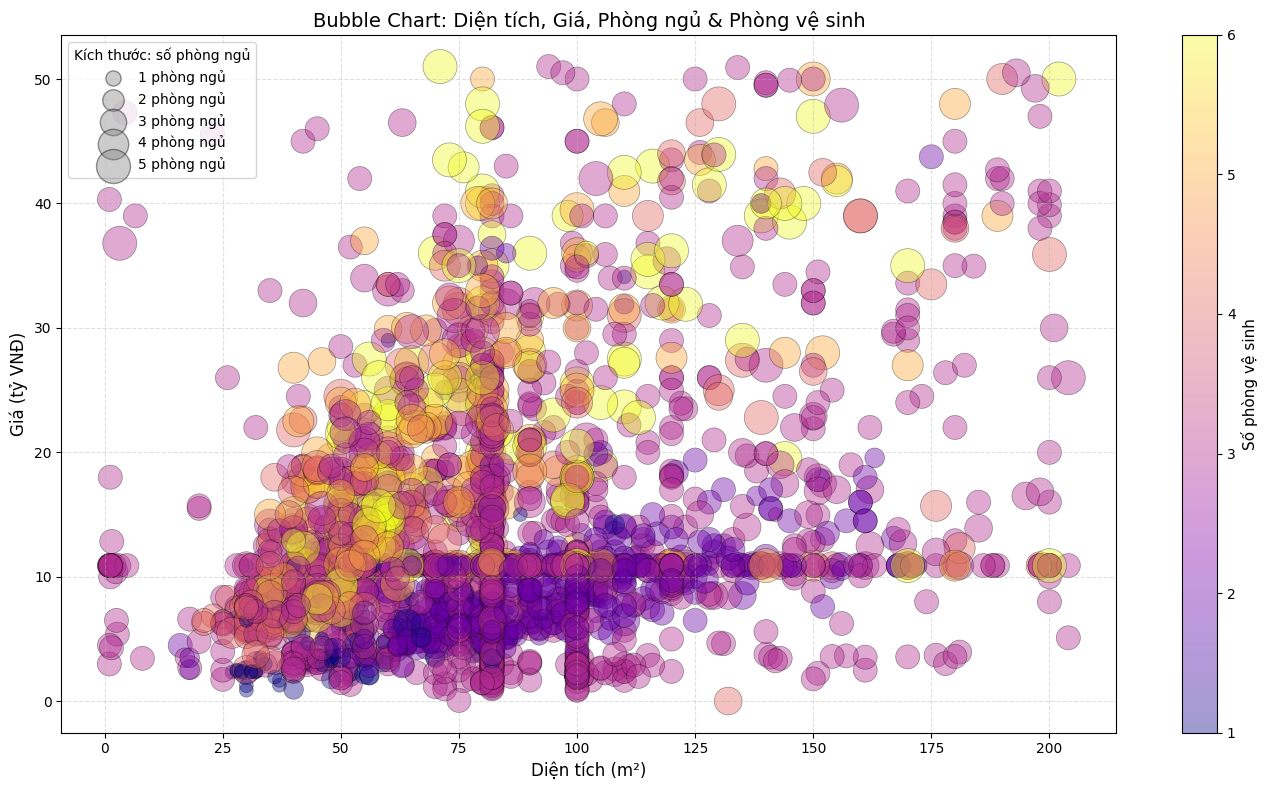

In [68]:
# Loại bỏ Missing và dữ liệu không hợp lệ
df = df.dropna(subset=['area_m2', 'price_ty', 'bedrooms_num', 'toilets_num'])

# Giới hạn kích thước để bong bóng không quá to
df['bedrooms_num'] = df['bedrooms_num'].clip(1, 6)
df['toilets_num'] = df['toilets_num'].clip(1, 6)


plt.figure(figsize=(14, 8))

bubble = plt.scatter(
    df['area_m2'], 
    df['price_ty'], 
    s=df['bedrooms_num'] * 100,     # Kích thước bong bóng ~ số phòng ngủ
    c=df['toilets_num'],            # Màu sắc ~ số phòng vệ sinh
    cmap='plasma',                  # Bảng màu rực, dễ phân biệt
    alpha=0.4,                      # Độ trong suốt
    edgecolor='k',                  # Viền đen giúp rõ ràng
    linewidth=0.5
)

# ----------------------------
# Trang trí biểu đồ
# ----------------------------
plt.title("Bubble Chart: Diện tích, Giá, Phòng ngủ & Phòng vệ sinh", fontsize=14)
plt.xlabel("Diện tích (m²)", fontsize=12)
plt.ylabel("Giá (tỷ VNĐ)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

# Thanh màu (colorbar)
cbar = plt.colorbar(bubble)
cbar.set_label("Số phòng vệ sinh", fontsize=11)

# Chú thích kích thước (phòng ngủ)
for i, size in enumerate([1,2,3,4,5]):
    plt.scatter([], [], s=size*120, c='gray', alpha=0.4, edgecolor='k', label=f'{size} phòng ngủ')

plt.legend(
    title='Kích thước: số phòng ngủ',
    loc='upper left',
    bbox_to_anchor=(0, 1.0)
)

# Lưu & hiển thị
plt.tight_layout()

output_path = os.path.join("img", "libubble_chart_4d_analysisne_chart.png")

plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


### 5.3. Histogram và mật độ

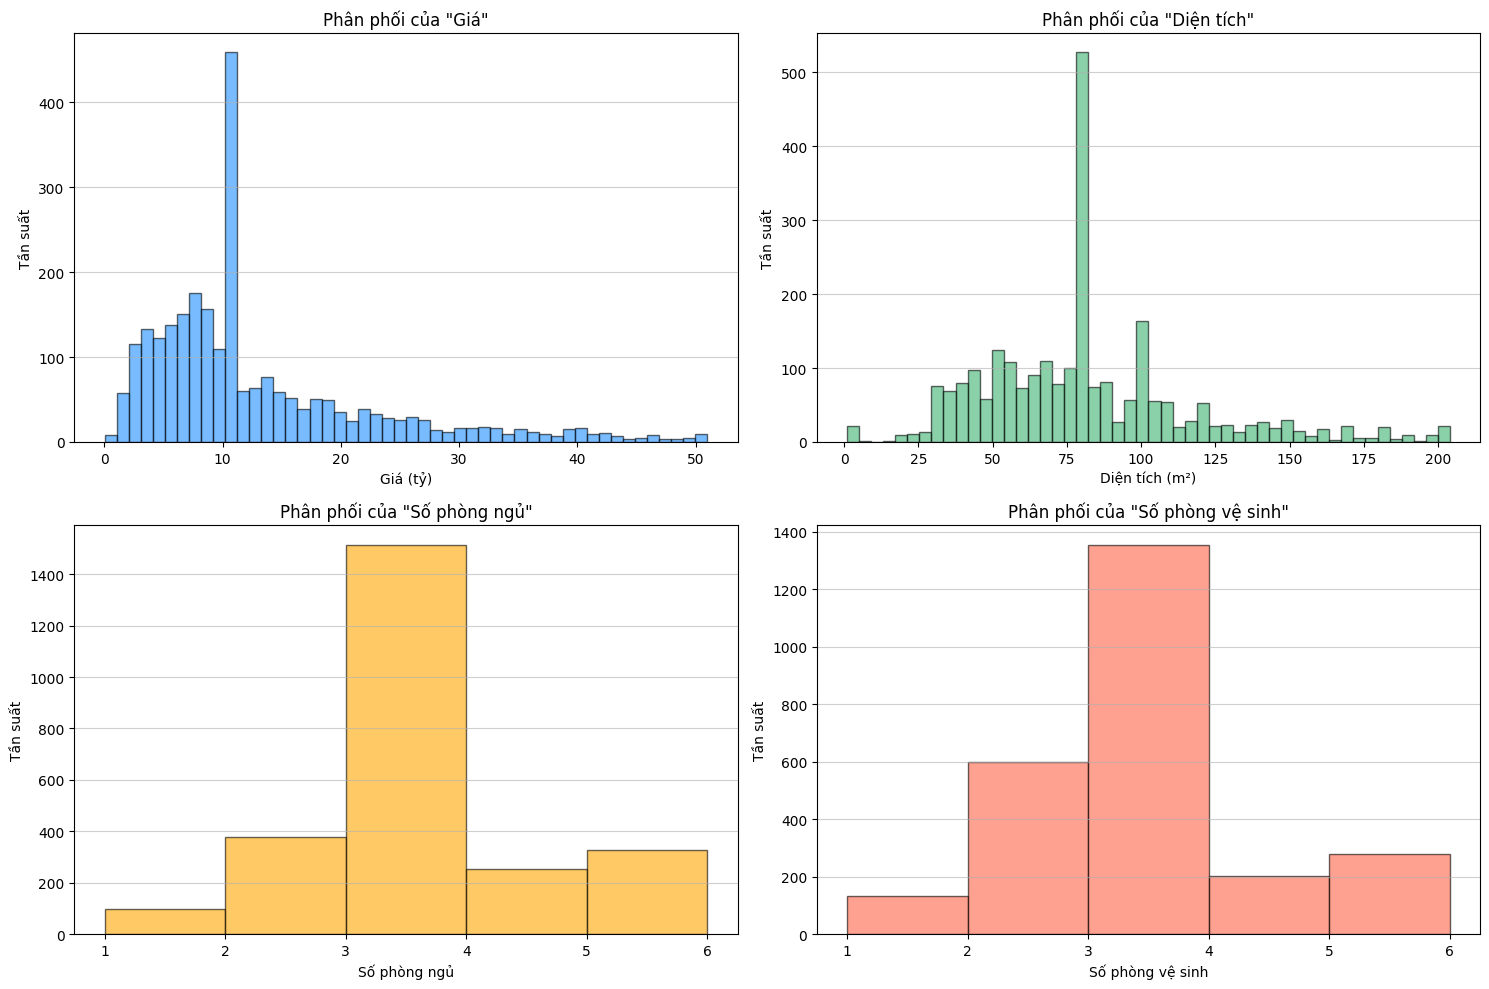

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Xác định min–max cho từng cột
price_min, price_max = df['price_ty'].min(), df['price_ty'].max()
area_min, area_max = df['area_m2'].min(), df['area_m2'].max()
bed_min, bed_max = df['bedrooms_num'].min(), df['bedrooms_num'].max()
toilet_min, toilet_max = df['toilets_num'].min(), df['toilets_num'].max()

# Tạo figure 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# --- Biểu đồ 1: Giá nhà ---
axes[0, 0].hist(df['price_ty'].dropna(),
                bins=np.arange(price_min, price_max + 1, (price_max - price_min)/50),
                color='dodgerblue', edgecolor='black', alpha=0.6)
axes[0, 0].set_title('Phân phối của "Giá"')
axes[0, 0].set_xlabel('Giá (tỷ)')
axes[0, 0].set_ylabel('Tần suất')
axes[0, 0].grid(axis='y', alpha=0.6)

# --- Biểu đồ 2: Diện tích ---
axes[0, 1].hist(df['area_m2'].dropna(),
                bins=np.arange(area_min, area_max + 1, (area_max - area_min)/50),
                color='mediumseagreen', edgecolor='black', alpha=0.6)
axes[0, 1].set_title('Phân phối của "Diện tích"')
axes[0, 1].set_xlabel('Diện tích (m²)')
axes[0, 1].set_ylabel('Tần suất')
axes[0, 1].grid(axis='y', alpha=0.6)

# --- Biểu đồ 3: Phòng ngủ ---
axes[1, 0].hist(df['bedrooms_num'].dropna(),
                bins=np.arange(bed_min, bed_max + 1, 1),
                color='orange', edgecolor='black', alpha=0.6)
axes[1, 0].set_title('Phân phối của "Số phòng ngủ"')
axes[1, 0].set_xlabel('Số phòng ngủ')
axes[1, 0].set_ylabel('Tần suất')
axes[1, 0].grid(axis='y', alpha=0.6)

# --- Biểu đồ 4: Phòng vệ sinh ---
axes[1, 1].hist(df['toilets_num'].dropna(),
                bins=np.arange(toilet_min, toilet_max + 1, 1),
                color='tomato', edgecolor='black', alpha=0.6)
axes[1, 1].set_title('Phân phối của "Số phòng vệ sinh"')
axes[1, 1].set_xlabel('Số phòng vệ sinh')
axes[1, 1].set_ylabel('Tần suất')
axes[1, 1].grid(axis='y', alpha=0.6)

plt.tight_layout()
output_path = os.path.join("img", "histograms_4_selected_fixed.png")
plt.savefig(output_path)
plt.show()


### 5.4. Trực quan hoá thanh lỗi

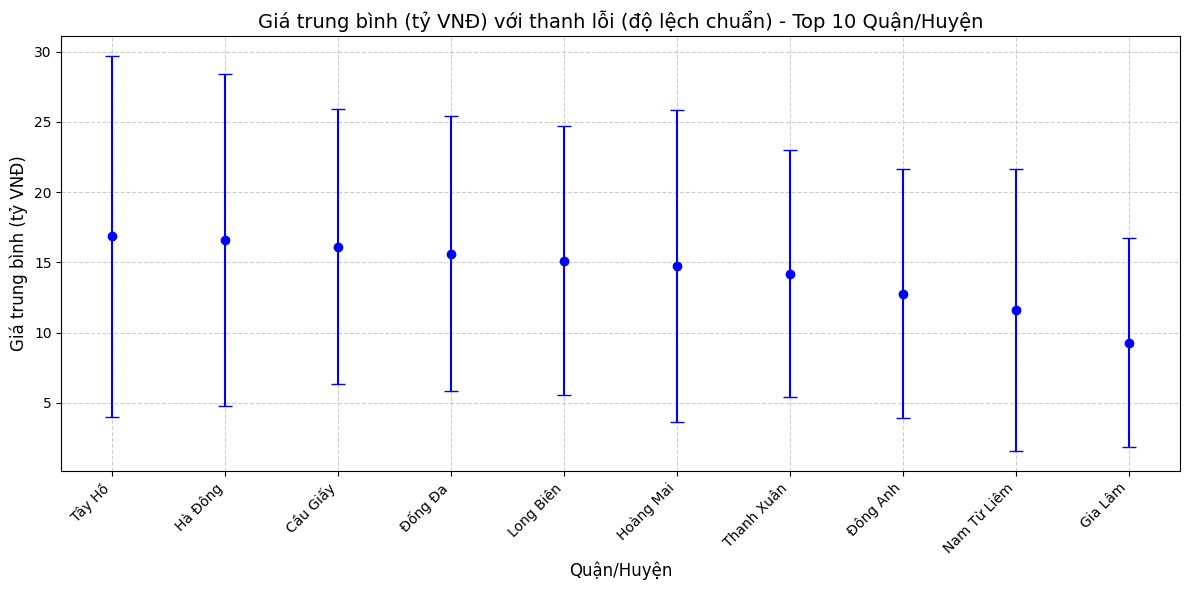

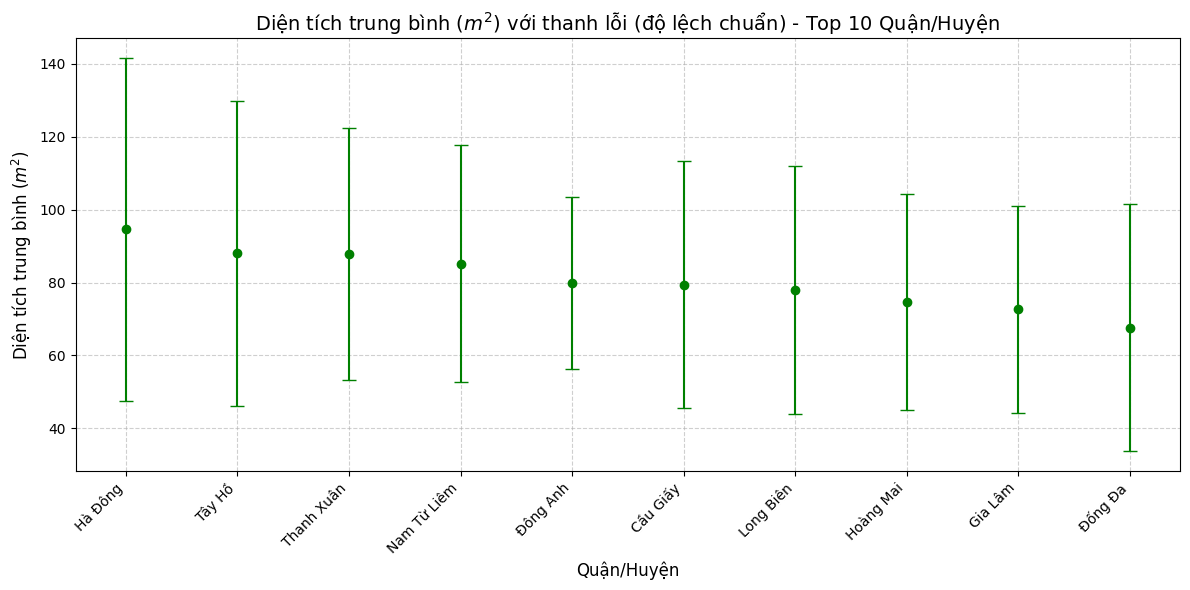

In [77]:
# Loại bỏ giá trị thiếu trong các cột cần dùng
df = df.dropna(subset=["address", "price_ty", "area_m2"])


grouped = (
    df.groupby("district")[["price_ty", "area_m2"]]
    .agg(["mean", "std", "count"])
    .reset_index()
)

grouped.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in grouped.columns.values]

grouped = grouped.rename(columns={
    'price_ty_mean': 'price_mean',
    'price_ty_std': 'price_std',
    'area_m2_mean': 'area_mean',
    'area_m2_std': 'area_std',
    'price_ty_count': 'count'
})[['district', 'price_mean', 'price_std', 'area_mean', 'area_std', 'count']]


#  top 10 quận có nhiều mẫu nhất
grouped_top = grouped.sort_values("count", ascending=False).head(10)


# Sắp xếp top 10 theo giá trung bình giảm dần để dễ so sánh
grouped_top_price = grouped_top.sort_values("price_mean", ascending=False)

plt.figure(figsize=(12, 6))
plt.errorbar(
    grouped_top_price["district"],
    grouped_top_price["price_mean"],
    yerr=grouped_top_price["price_std"],
    fmt="o",
    capsize=5,
    color="blue",
)
plt.xticks(rotation=45, ha="right")
plt.title("Giá trung bình (tỷ VNĐ) với thanh lỗi (độ lệch chuẩn) - Top 10 Quận/Huyện", fontsize=14)
plt.xlabel("Quận/Huyện", fontsize=12)
plt.ylabel("Giá trung bình (tỷ VNĐ)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
output_path = os.path.join("img", "errorbar_price_by_district_fixed.png")

plt.savefig(output_path, dpi=300, bbox_inches="tight")


# Sắp xếp top 10 theo diện tích trung bình giảm dần để dễ so sánh
grouped_top_area = grouped_top.sort_values("area_mean", ascending=False)

plt.figure(figsize=(12, 6))
plt.errorbar(
    grouped_top_area["district"],
    grouped_top_area["area_mean"],
    yerr=grouped_top_area["area_std"],
    fmt="o",
    capsize=5,
    color="green",
)
plt.xticks(rotation=45, ha="right")
plt.title("Diện tích trung bình ($m^2$) với thanh lỗi (độ lệch chuẩn) - Top 10 Quận/Huyện", fontsize=14)
plt.xlabel("Quận/Huyện", fontsize=12)
plt.ylabel("Diện tích trung bình ($m^2$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
output_path = os.path.join("img", "errorbar_area_by_district_fixed.png")

plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close() 